# Imports

In [3]:
%load_ext autoreload
%autoreload 2

# og python libs
import re
import os
import pprint
import itertools
from typing import Tuple, List, Dict, Pattern, Any


# classic DS libs
import pandas as pd
import numpy as np

# viz libs
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from ipywidgets import interact, fixed, interact_manual

# scipy
from scipy.integrate import quad
from scipy.signal import find_peaks, peak_widths, find_peaks_cwt
from scipy.constants import k as k_B
from scipy.constants import c, pi, N_A, h, hbar, m_e, m_p

# lmfit things
from lmfit.models import LinearModel, GaussianModel, VoigtModel, SplineModel, ExponentialModel, ExpressionModel, Model, ConstantModel
from lmfit import Parameter, Parameters
from lmfit import minimize, minimizer

# ML
from sklearn.linear_model import LinearRegression

# GenAI
from google import genai
from google.genai import types

# natural data databases
import hapi
DB_PATH = 'hapi_data'
hapi.db_begin(DB_PATH)

# API setups
G_MODEL_ID = "gemini-flash-latest"
G_API_KEY = os.environ.get("GEMINI_API_KEY")
G_CLIENT = genai.Client(api_key=G_API_KEY)

response = G_CLIENT.models.generate_content(
    model=G_MODEL_ID,
    contents="test",
)

print(response.text)

pp = pprint.PrettyPrinter(depth=4)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using hapi_data

I see you've sent "test". How can I help you today?

For example, are you looking to:

1. **Test the functionality** of this AI?
2. **Start a specific topic** (like writing, coding, or general knowledge)?
3. **Just saying hello**?


In [4]:
# custom
import sys
sys.path.append('../../../../../../')
from my_utils import defs as cp
from my_utils.classes import CEPAS_measurement, CEPAS_benchmark, CEPAS_noise_info, CEPAS_SNR_bench
cp.hello_test()

Hello!


# Benchmark

In [5]:
pressure_list = [300, 600, 900]
freq_list_2 = [30, 40, 80, 90, 130, 170, 220, 300]

benchmark_path_2 = "./"
benchmark_noise_2 = "./noise-tests/"

patterns = cp.create_regex_strings(pressure_list, freq_list_2)

test_bench_files = cp.dir_match_dict(benchmark_path_2, patterns) 
# pp.pprint(patterns)
pp.pprint(test_bench_files)

{300: {30: [], 40: [], 80: [], 90: [], 130: [], 170: [], 220: [], 300: []},
 600: {30: [], 40: [], 80: [], 90: [], 130: [], 170: [], 220: [], 300: []},
 900: {30: ['gasx_900_32_30__msr__0'],
       40: [],
       80: [],
       90: [],
       130: [],
       170: [],
       220: [],
       300: []}}


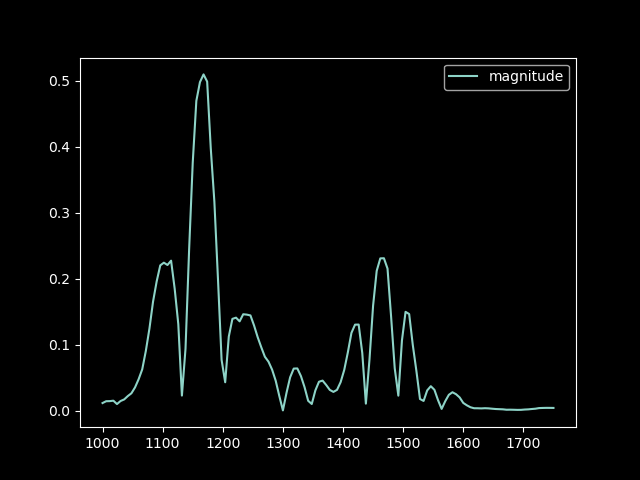

,time,offset1,P1,H3,H2,P_las,T_las,RH,Pressure,time_subtracted,H2_pnorm,H3_pnorm,wavenumbers,magnitude_pnorm
1,2091.323,1000.0,0.0,0.000960,-0.000955,0.115788,393.6961,25.31738,896.0,0.000,-0.008072,0.008115,6985.643439,0.011446
2,2093.131,1006.0,0.0,0.001110,-0.001264,0.115788,393.6961,25.31738,896.0,1.808,-0.010682,0.009385,6985.617254,0.014220
3,2094.936,1012.0,0.0,0.001386,-0.001194,0.124883,403.5192,25.31738,896.0,3.613,-0.009371,0.010877,6985.591070,0.014357
4,2096.738,1018.0,0.0,0.001518,-0.001168,0.124883,403.5192,25.31738,896.0,5.415,-0.009167,0.011920,6985.564885,0.015037
5,2098.442,1024.0,0.0,0.001105,-0.000614,0.124883,403.5192,25.31738,896.0,7.119,-0.004821,0.008678,6985.538700,0.009927


In [7]:


u1 = [1158.1, 1452.7]
u2 = [6984.9534710, 6983.6678]

# REMINDER frequencies: [20, 30, 40, 80, 90, 130, 170, 220, 300]
p = 900
f = 30
bench_test_2 = CEPAS_benchmark(benchmark_path_2, test_bench_files, p, f)
# bench_test.self_test()
bench_test_2.add_wav(u1, u2)
bench_test_2.add_magnitude()
test_avg = bench_test_2.get_avg()
target_peak = (1400, 1550)
bench_peaks = find_peaks_cwt(test_avg['H2_pnorm'], 10.0)
# print(bench_peaks)
# print(test_300_20)
%matplotlib widget

plt.close()
plt.figure()
# 1st test
# plt.plot(bench_test_2.spectra.spectra_list[0]['offset1'], bench_test_2.spectra.spectra_list[0]['H2_pnorm'])
# plt.plot(bench_test_2.spectra.spectra_list[1]['offset1'], bench_test_2.spectra.spectra_list[1]['H2_pnorm'])
# plt.plot(bench_test_2.spectra.spectra_list[2]['offset1'], bench_test_2.spectra.spectra_list[2]['H2_pnorm'])
# plt.plot(test_avg['offset1'][bench_peaks], test_avg['H2_pnorm'][bench_peaks], 'rx')
# plt.plot(test_avg['offset1'], test_avg['H2_pnorm'], label='avg')

# test magnitude
plt.plot(test_avg['offset1'], test_avg["magnitude_pnorm"], label="magnitude")

plt.legend()
# plt.xlim(1625, 1750)
# plt.ylim(-0.008, -0.0015)
plt.show()
bench_test_2.spectra.spectra_list[0].head()

# Signal

Uncomment below to see all the peaks used for bench

In [8]:
plt.close()
ps = [300, 600, 900]
fs = [30, 40, 80, 90, 130, 170, 220, 300]
for p, f in itertools.product(ps, fs):
    bench_test = CEPAS_benchmark(benchmark_path_2, test_bench_files, p, f)
    bench_test.add_magnitude()
    peak_start = 1449
    peak_end = 1471
    peak = bench_test.get_window(peak_start, peak_end)
    peak_spline = bench_test.get_spline_of_window(n_spectrum=-1,
                                                  n_knots=4,
                                                  colx="offset1",
                                                  coly="magnitude_pnorm",
                                                  start=peak_start,
                                                  end=peak_end)
    # print(peak_spline[1])
    print(peak_spline[-1])
    plt.figure()
    plt.plot(peak[0]['offset1'], peak[0]['magnitude_pnorm'])
    plt.plot(peak[1]['offset1'], peak[1]["magnitude_pnorm"])
    plt.plot(peak[2]['offset1'], peak[2]["magnitude_pnorm"])
    plt.plot(peak[3]['offset1'], peak[3]['magnitude_pnorm'], label='avg')
    plt.scatter(peak_spline[2]['offset1'], peak_spline[2]['magnitude_pnorm'], label='spline of avg')
    plt.plot(peak_spline[-2]['offset1'], peak_spline[-2]['magnitude_pnorm'], 'rx')
    plt.legend()
    plt.title(f"p={p}, f={f}")
    plt.show()

Low importance variable, replaced with none                   
 error: zero-size array to reduction operation maximum which has no identity


ValueError: zero-size array to reduction operation minimum which has no identity

# Noise

In [9]:
bench_noise_300_2 = CEPAS_noise_info(benchmark_noise_2, 300)
bench_noise_600_2 = CEPAS_noise_info(benchmark_noise_2, 600)
bench_noise_900_2 = CEPAS_noise_info(benchmark_noise_2, 900)

backgrounds = {300: bench_noise_300_2,
               600: bench_noise_600_2,
               900: bench_noise_900_2}


print(f"{np.format_float_scientific(bench_noise_300_2.get_noise_at(f), precision=3)}")
plt.close()
plt.figure(figsize=(11, 5))
plt.subplot(131)
plt.title("$300\\ \\text{mbar}$")
plt.xlabel('Frequency, Hz')
plt.ylabel('Intensity, arb.u.')
plt.plot(bench_noise_300_2.spectrum['freq'], bench_noise_300_2.spectrum['intensity'])
plt.subplot(132)
plt.title("$600\\ \\text{mbar}$")
plt.xlabel('Frequency, Hz')
plt.ylabel('Intensity, arb.u.')
plt.plot(bench_noise_600_2.spectrum['freq'], bench_noise_600_2.spectrum['intensity'])
plt.subplot(133)
plt.title("$900\\ \\text{mbar}$")
plt.xlabel('Frequency, Hz')
plt.ylabel('Intensity, arb.u.')
plt.plot(bench_noise_900_2.spectrum['freq'], bench_noise_900_2.spectrum['intensity'])
plt.tight_layout()
plt.show()

IndexError: list index out of range

In [10]:
noise_start_2 = 1625
noise_end_2 = 1749
peak_start_2 = 1449
peak_end_2 = 1471

bench_final_2 = CEPAS_SNR_bench(test_bench_files,
                                bench_path=benchmark_path_2,
                                noise_path=benchmark_noise_2,
                                file_sig="single")

get_all = bench_final_2.get_mag_snrs(peak_start_2,
                                     peak_end_2,
                                     n_knots=4)

snrs = get_all[0]
noises = get_all[1]  # single, background
signals = get_all[2]

signals.index
bench_final_2

Low importance variable, replaced with none                   
 error: zero-size array to reduction operation maximum which has no identity
Wrong filename, changed:
'single'->'gasx', zero-size array to reduction operation minimum which has no identity
Low importance variable, replaced with none                   
 error: zero-size array to reduction operation maximum which has no identity


ValueError: zero-size array to reduction operation minimum which has no identity

In [11]:
noises

NameError: name 'noises' is not defined

In [12]:
signals300 = {
    'signal': [float(signals[300][f][0]) for f in signals.index],
    # 'background': [float(signals[300][f][1]) for f in signals.index]
}

signals600 = {
    'signal': [float(signals[600][f][0]) for f in signals.index],
    # 'background': [float(signals[600][f][1]) for f in signals.index]
}

signals900 = {
    'signal': [float(signals[900][f][0]) for f in snrs.index],
    # 'background': [float(signals[900][f][1]) for f in snrs.index]
}

frequencies = snrs.index
x = np.arange(len(frequencies))
width = 0.1
multiplier = 0
spacing = 0.05
top_align = 1.3

plt.close()
plt.figure(figsize=(11, 15), constrained_layout=True)

ax1 = plt.subplot(311)
for k, v in signals300.items():
    offset = (width+spacing) * multiplier
    rects = ax1.bar(x+offset, v, width, label=k)
    ax1.bar_label(rects, rotation=90, padding=3)
    multiplier += 1
ax1.set_xticks(x+width, np.round(list(frequencies), 2))
ax1.set_xlabel('Frequency, Hz')
ax1.set_ylabel('Signal, arb.u.')
old_top = ax1.get_ylim()[1]
new_top = old_top*top_align
ax1.set_ylim(top=new_top)
ax1.legend()
multiplier = 0

ax2 = plt.subplot(312)
for k, v in signals600.items():
    offset = (width+spacing) * multiplier
    rects = ax2.bar(x+offset, v, width, label=k)
    ax2.bar_label(rects, rotation=90, padding=3)
    multiplier += 1
ax2.set_xticks(x+width, np.round(list(frequencies), 2))
ax2.set_xlabel('Frequency, Hz')
ax2.set_ylabel('Signal, arb.u.')
old_top = ax2.get_ylim()[1]
new_top = old_top*top_align
ax2.set_ylim(top=new_top)
ax2.legend()
multiplier = 0

ax3 = plt.subplot(313)
for k, v in signals900.items():
    offset = (width+spacing) * multiplier
    rects = ax3.bar(x+offset, v, width, label=k)
    ax3.bar_label(rects, rotation=90, padding=3)
    multiplier += 1
ax3.set_xticks(x+width, np.round(list(frequencies), 2))
ax3.set_xlabel('Frequency, Hz')
ax3.set_ylabel('Signal, arb.u.')
old_top = ax3.get_ylim()[1]
new_top = old_top*top_align
ax3.set_ylim(top=new_top)
ax3.legend()

plt.tight_layout(pad=5)
plt.show()

NameError: name 'signals' is not defined

In [13]:
noises300 = {
    'single': [noises[300][f][0] for f in noises.index],
    'background': [noises[300][f][1] for f in noises.index]
}

noises600 = {
    'single': [noises[600][f][0] for f in noises.index],
    'background': [noises[600][f][1] for f in noises.index]
}

noises900 = {
    'single': [noises[900][f][0] for f in noises.index],
    'background': [noises[900][f][1] for f in noises.index]
}

frequencies = noises.index
x = np.arange(len(frequencies))
width = 0.1
multiplier = 0
spacing = 0.05
top_align = 1.3

plt.close()
plt.figure(figsize=(11, 15), constrained_layout=True)

ax1 = plt.subplot(311)
for k, v in noises300.items():
    offset = (width+spacing) * multiplier
    rects = ax1.bar(x+offset, v, width, label=k)
    ax1.bar_label(rects, rotation=90, padding=3, fmt="%.3e")
    multiplier += 1
ax1.set_xticks(x+width, np.round(list(frequencies), 2))
ax1.set_xlabel('Frequency, Hz')
ax1.set_ylabel('Noise, st.dev. of arb.u.')
old_top = ax1.get_ylim()[1]
new_top = old_top*top_align
ax1.set_ylim(top=new_top)
ax1.legend()
multiplier = 0

ax2 = plt.subplot(312)
for k, v in noises600.items():
    offset = (width+spacing) * multiplier
    rects = ax2.bar(x+offset, v, width, label=k)
    ax2.bar_label(rects, rotation=90, padding=3, fmt="%.3e")
    multiplier += 1
ax2.set_xticks(x+width, np.round(list(frequencies), 2))
ax2.set_xlabel('Frequency, Hz')
ax2.set_ylabel('Noise, st.dev. of arb.u.')
old_top = ax2.get_ylim()[1]
new_top = old_top*top_align
ax2.set_ylim(top=new_top)
ax2.legend()
multiplier = 0

ax3 = plt.subplot(313)
for k, v in noises900.items():
    offset = (width+spacing) * multiplier
    rects = ax3.bar(x+offset, v, width, label=k)
    ax3.bar_label(rects, rotation=90, padding=3, fmt="%.3e")
    multiplier += 1
ax3.set_xticks(x+width, np.round(list(frequencies), 2))
ax3.set_xlabel('Frequency, Hz')
ax3.set_ylabel('Noise, st.dev. of arb.u.')
old_top = ax3.get_ylim()[1]
new_top = old_top*top_align
ax3.set_ylim(top=new_top)
ax3.legend()

plt.tight_layout(pad=5)
plt.show()

NameError: name 'noises' is not defined

In [14]:
snrs300 = {
    'single': [snrs[300][f][0] for f in snrs.index],
    'background': [snrs[300][f][1] for f in snrs.index]
}

snrs600 = {
    'single': [snrs[600][f][0] for f in snrs.index],
    'background': [snrs[600][f][1] for f in snrs.index]
}

snrs900 = {
    'single': [snrs[900][f][0] for f in snrs.index],
    'background': [snrs[900][f][1] for f in snrs.index]
}

frequencies = snrs.index
x = np.arange(len(frequencies))
width = 0.1
multiplier = 0
spacing = 0.05
top_align = 1.3

plt.close()
plt.figure(figsize=(11, 15), constrained_layout=True)

ax1 = plt.subplot(311)
for k, v in snrs300.items():
    offset = (width+spacing) * multiplier
    rects = ax1.bar(x+offset, v, width, label=k)
    ax1.bar_label(rects, rotation=90, padding=3, fmt="%.3e")
    multiplier += 1
ax1.set_xticks(x+width, np.round(list(frequencies), 2))
ax1.set_xlabel('Frequency, Hz')
ax1.set_ylabel('SNR, arb.u.')
old_top = ax1.get_ylim()[1]
new_top = old_top*top_align
ax1.set_ylim(top=new_top)
ax1.legend()
multiplier = 0

ax2 = plt.subplot(312)
for k, v in snrs600.items():
    offset = (width+spacing) * multiplier
    rects = ax2.bar(x+offset, v, width, label=k)
    ax2.bar_label(rects, rotation=90, padding=3, fmt="%.3e")
    multiplier += 1
ax2.set_xticks(x+width, np.round(list(frequencies), 2))
ax2.set_xlabel('Frequency, Hz')
ax2.set_ylabel('SNR, arb.u.')
old_top = ax2.get_ylim()[1]
new_top = old_top*top_align
ax2.set_ylim(top=new_top)
ax2.legend()
multiplier = 0

ax3 = plt.subplot(313)
for k, v in snrs900.items():
    offset = (width+spacing) * multiplier
    rects = ax3.bar(x+offset, v, width, label=k)
    ax3.bar_label(rects, rotation=90, padding=3, fmt="%.3e")
    multiplier += 1
ax3.set_xticks(x+width, np.round(list(frequencies), 2))
ax3.set_xlabel('Frequency, Hz')
ax3.set_ylabel('SNR, arb.u.')
old_top = ax3.get_ylim()[1]
new_top = old_top*top_align
ax3.set_ylim(top=new_top)
ax3.legend()

plt.tight_layout(pad=5)
plt.show()

NameError: name 'snrs' is not defined